In [1]:
from typing import List

import aesara.tensor as aet
import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import xarray
from scipy import linalg, spatial, special
from scipy.special import expit as logistic

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


In [2]:
arviz.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

## Data

In [3]:
polls = pd.read_csv(
    "../../data/polls_1st_round/tour1_complet_unitedfl.csv",
    index_col=0,
    parse_dates=["dateelection", "date"],
)
polls = (
    polls[
        (polls.dateelection == "2017-04-23")
        & (polls.date >= "2017-01")
        & (polls.sondage != "result")
    ]
    .drop(
        [
            "type",
            "dateelection",
            "abstention",
            "undecided",
        ],
        axis=1,
    )
    .set_index(["date", "sondage", "samplesize"])
    .sort_index()
)

In [4]:
COORDS = {
    "parties": ["farleft", "left", "green", "center", "right", "farright"],
    "parties_complete": [
        "farleft",
        "left",
        "green",
        "center",
        "right",
        "farright",
        "other",
    ],
    "observations": polls.index,
}

In [5]:
# compute "other" category
polls = polls.rename(
    columns={col: col.split("nb")[1] for col in polls if col.startswith("nb")}
)[COORDS["parties"]]
polls["other"] = 100 - polls.sum(1)
polls = polls.reset_index(level="samplesize")

In [6]:
data = polls.reset_index()
fig, ax = plt.subplots(figsize=(12, 5))
for p in COORDS["parties_complete"]:
    ax.plot(data["date"], data[p], "o", label=p, alpha=0.4)
ax.legend(ncol=4, frameon=True, loc="upper right");

In [7]:
# cast as multinomial obs
polls[COORDS["parties_complete"]] = (
    (polls[COORDS["parties_complete"]] / 100)
    .mul(polls["samplesize"], axis=0)
    .round()
    .fillna(0)
    .astype(int)
)
polls["samplesize"] = polls[COORDS["parties_complete"]].sum(1)
polls = polls.reset_index()
polls

date sondage  samplesize  farleft  left  green  center  right  \
0   2017-01-04   Elabe         996      144    60     15     229    259   
1   2017-01-04   Elabe         995      129    60     10     209    239   
2   2017-01-04    Ifop        1472      169    88     29     280    361   
3   2017-01-07     BVA         946      118    57     24     189    227   
4   2017-01-12   Ipsos       15919     2229  1114    398    3343   3980   
..         ...     ...         ...      ...   ...    ...     ...    ...   
139 2017-04-20   Elabe        1196      233    84      0     287    239   
140 2017-04-20    Ifop        1901      352   133      0     466    370   
141 2017-04-20   Ipsos        1400      266   105      0     336    266   
142 2017-04-21     BVA        1134      221    91      0     261    215   
143 2017-04-21   Odoxa         667      127    50      0     163    127   

     farright  other  
0         239     50  
1         229    119  
2         383    162  
3         246     85  
4        4139    716  
..        ...    ...  
139       257     96  
140       428    152  
141       308    119  
142       261     85  
143       153     47  

[144 rows x 10 columns]

In [8]:
def dates_to_idx(timelist):
    """Convert datetimes to numbers in reference to a given date"""

    reference_time = timelist[0]
    t = (timelist - reference_time) / np.timedelta64(1, "D")

    return np.asarray(t)

## GP approximation

In [9]:
def make_sum_zero_hh(N: int) -> np.ndarray:
    """
    Build a householder transformation matrix that maps e_1 to a vector of all 1s.
    """
    e_1 = np.zeros(N)
    e_1[0] = 1
    a = np.ones(N)
    a /= np.sqrt(a @ a)
    v = a + e_1
    v /= np.sqrt(v @ v)

    return np.eye(N) - 2 * np.outer(v, v)

In [10]:
def make_centered_gp_eigendecomp(
    time: np.ndarray,
    lengthscales: List[float],
    variance_limit: float = 0.95,
    metric: str = "euclidean",
    zerosum: bool = False,
):
    """
    Decompose the GP into eigen values and eigen vectors.

    Parameters
    ----------
    time: np.ndarray
        Array containing the time points of observations.
    lengthscales: List[float]
        Length scale parameter of the GP. Set in the ``config`` dictionary.
    variance_limit: float, defaults to 0.95
        Controls how many of the eigen vectors of the GP are used. So, if
        ``variance_limit=1``, all eigen vectors are used.
    metric: str, defaults to "euclidean"
        Experimental. Used to estimate the distance between ranges and rows.
    zerosum: bool, default=False
        Constrain all basis functions to sum(basis) = 0.

    Notes
    -----
    Makes sure that the GP effect sums to zero across plots of each field.
    """

    ## Construct covariance matrix
    X = time[:, None]
    X_norm = X / np.array(lengthscales)
    dists = spatial.distance.cdist(X_norm, X_norm, metric=metric)
    cov = np.exp(-(dists ** 2) / 2)

    if zerosum:
        Q = make_sum_zero_hh(len(cov))
        D = np.eye(len(cov))
        D[0, 0] = 0

        # 1) Transform the covariance matrix so that the first entry
        # is the mean: A = Q @ cov @ Q.T
        # 2) Project onto the subspace without the mean: B = D @ A @ D
        # 3) Transform the result back to the original space: Q.T @ B @ Q
        cov = Q.T @ D @ Q @ cov @ Q.T @ D @ Q

    vals, vecs = linalg.eigh(cov)
    n_eigs = ((vals[::-1].cumsum() / vals.sum()) > variance_limit).nonzero()[0][0]

    return vecs[:, -n_eigs:] * np.sqrt(vals[-n_eigs:])

In [11]:
day_idx = dates_to_idx(polls.date).astype(int)
days = np.arange(day_idx.max() + 1)

gp_basis = make_centered_gp_eigendecomp(
    days,
    lengthscales=1.,
)

COORDS["days"] = days
COORDS["gp_basis"] = pd.RangeIndex(gp_basis.shape[-1])

In [18]:
with pm.Model(coords=COORDS) as m_simple:
    #n_cutpoints = len(COORDS["parties"])
    #cut_base = pm.Normal("cut_base", mu=-1, sigma=1)
    #cut_diffs = pm.HalfNormal("cut_diffs", sigma=2 / n_cutpoints, shape=n_cutpoints - 1)

    #cutpoints = pm.Deterministic(
     #   "cutpoints",
      #  aet.concatenate([[cut_base], cut_base + cut_diffs.cumsum()]),
       # dims="parties",
    #)
    
    gps = []
    for p in COORDS["parties"]:
        sd = pm.HalfNormal(f"time_weight_{p}", 0.5)
        coefs = pm.Normal(f"time_coefs_{p}", dims="gp_basis")
        gp_party = aet.dot(gp_basis, sd * coefs)
        gps.append(gp_party)
        pm.Deterministic(f"time_effect_{p}", gp_party, dims="days")
    
    ordered_gps = pm.Deterministic(
        "cutpoints",
        aet.log(aet.cumsum(aet.exp(aet.as_tensor_variable(gps).T), axis=-1)),
        dims=("days", "parties"),
    )
    # ordered_gps = [gp0, *(gp0 + cumsum(exp([gp1, gp2])))]

    pm.OrderedMultinomial(
        "results",
        eta=0.,
        cutpoints=ordered_gps[day_idx],
        n=polls["samplesize"].values,
        observed=polls[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )
    
    trace_simple = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["day_idx", "parties_complete"]},
            coords={
                "day_idx": day_idx,
                "parties_complete": COORDS["parties_complete"],
            },
        ),
    )

[108   6]
[648]
[108   6]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [time_weight_farleft, time_coefs_farleft, time_weight_left, time_coefs_left, time_weight_green, time_coefs_green, time_weight_center, time_coefs_center, time_weight_right, time_coefs_right, time_weight_farright, time_coefs_farright]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 240 seconds.


0, dim: observations, 144 =? 144


In [20]:
arviz.summary(trace_simple, var_names=["~time_effect", "~results_probs"], filter_vars="regex", round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
time_weight_farleft    1.48  0.12    1.26     1.71       0.00     0.00   
time_coefs_farleft[0]  0.01  0.18   -0.35     0.33       0.00     0.00   
time_coefs_farleft[1] -0.10  0.25   -0.60     0.35       0.00     0.00   
time_coefs_farleft[2] -0.28  0.31   -0.82     0.34       0.01     0.00   
time_coefs_farleft[3] -0.08  0.38   -0.81     0.62       0.01     0.01   
...                     ...   ...     ...      ...        ...      ...   
cutpoints[107,1]      -0.89  0.04   -0.97    -0.82       0.00     0.00   
cutpoints[107,2]      -0.89  0.04   -0.97    -0.81       0.00     0.00   
cutpoints[107,3]       0.07  0.04   -0.01     0.13       0.00     0.00   
cutpoints[107,4]       0.83  0.04    0.76     0.91       0.00     0.00   
cutpoints[107,5]       2.34  0.07    2.21     2.47       0.00     0.00   

                       ess_bulk  ess_tail  r_hat  
time_weight_farleft     3319.61   3004.94    1.0  
time_coefs_farleft[0]   4669.37   3134.13    1.0  
time_coefs_farleft[1]   4069.64   3139.52    1.0  
time_coefs_farleft[2]   3234.48   3020.79    1.0  
time_coefs_farleft[3]   3020.64   2806.46    1.0  
...                         ...       ...    ...  
cutpoints[107,1]        3983.97   3971.43    1.0  
cutpoints[107,2]        3980.31   3889.96    1.0  
cutpoints[107,3]        4050.51   3860.18    1.0  
cutpoints[107,4]        4017.76   3470.06    1.0  
cutpoints[107,5]        3773.87   3517.04    1.0  

[1056 rows x 9 columns]

In [21]:
arviz.summary(trace_simple, "time_effect", filter_vars="regex", kind="diagnostics")[
    ["ess_bulk", "ess_tail"]
].min()

ess_bulk    2440.0
ess_tail    2087.0
dtype: float64

In [22]:
arviz.summary(trace_simple, "results_probs", kind="diagnostics")[
    ["ess_bulk", "ess_tail"]
].min()

ess_bulk    2952.0
ess_tail    2221.0
dtype: float64

In [23]:
arviz.plot_ess(trace_simple, var_names=["time_weight", "time_coefs"], filter_vars="regex");

/Users/alex_andorra/opt/anaconda3/envs/pymc3-dev-py39/lib/python3.9/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (408) in plot_ess, generating only 40 plots
  warnings.warn(


/Users/alex_andorra/opt/anaconda3/envs/pymc3-dev-py39/lib/python3.9/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (408) in plot_ess, generating only 40 plots
  warnings.warn(


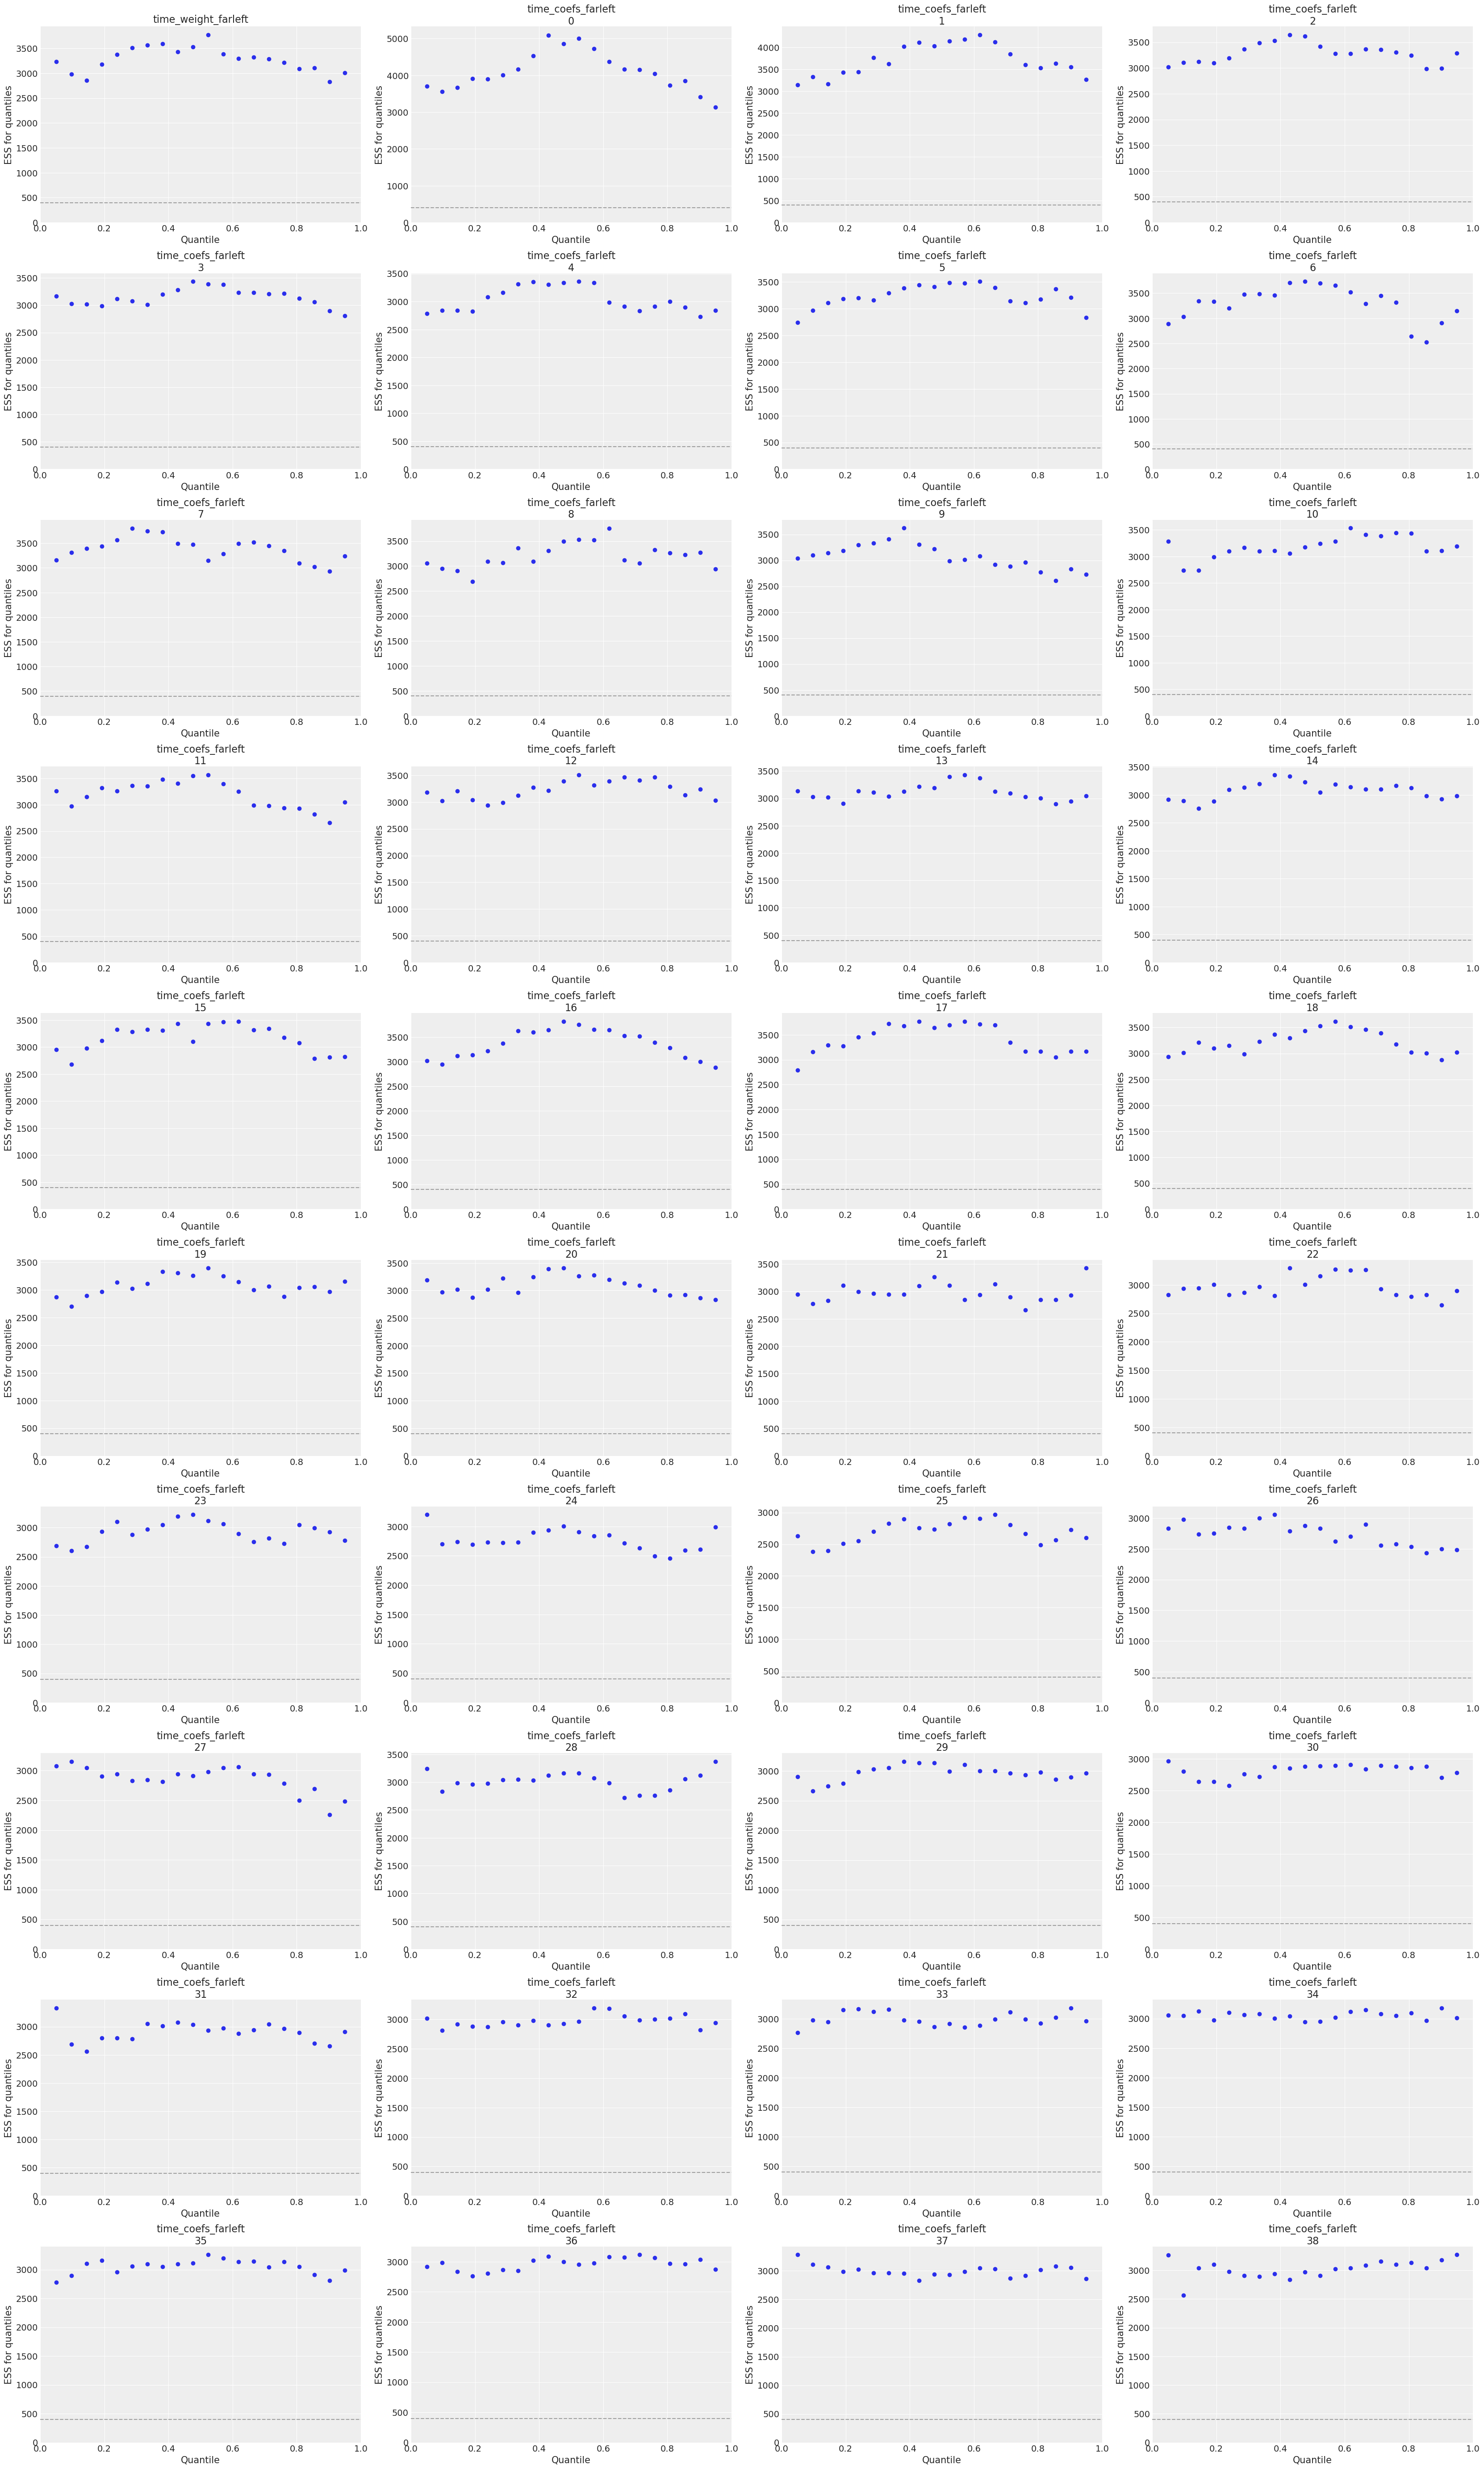

In [24]:
arviz.plot_ess(trace_simple, kind="quantile", var_names=["time_weight", "time_coefs"], filter_vars="regex");

/Users/alex_andorra/opt/anaconda3/envs/pymc3-dev-py39/lib/python3.9/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (408) in plot_ess, generating only 40 plots
  warnings.warn(


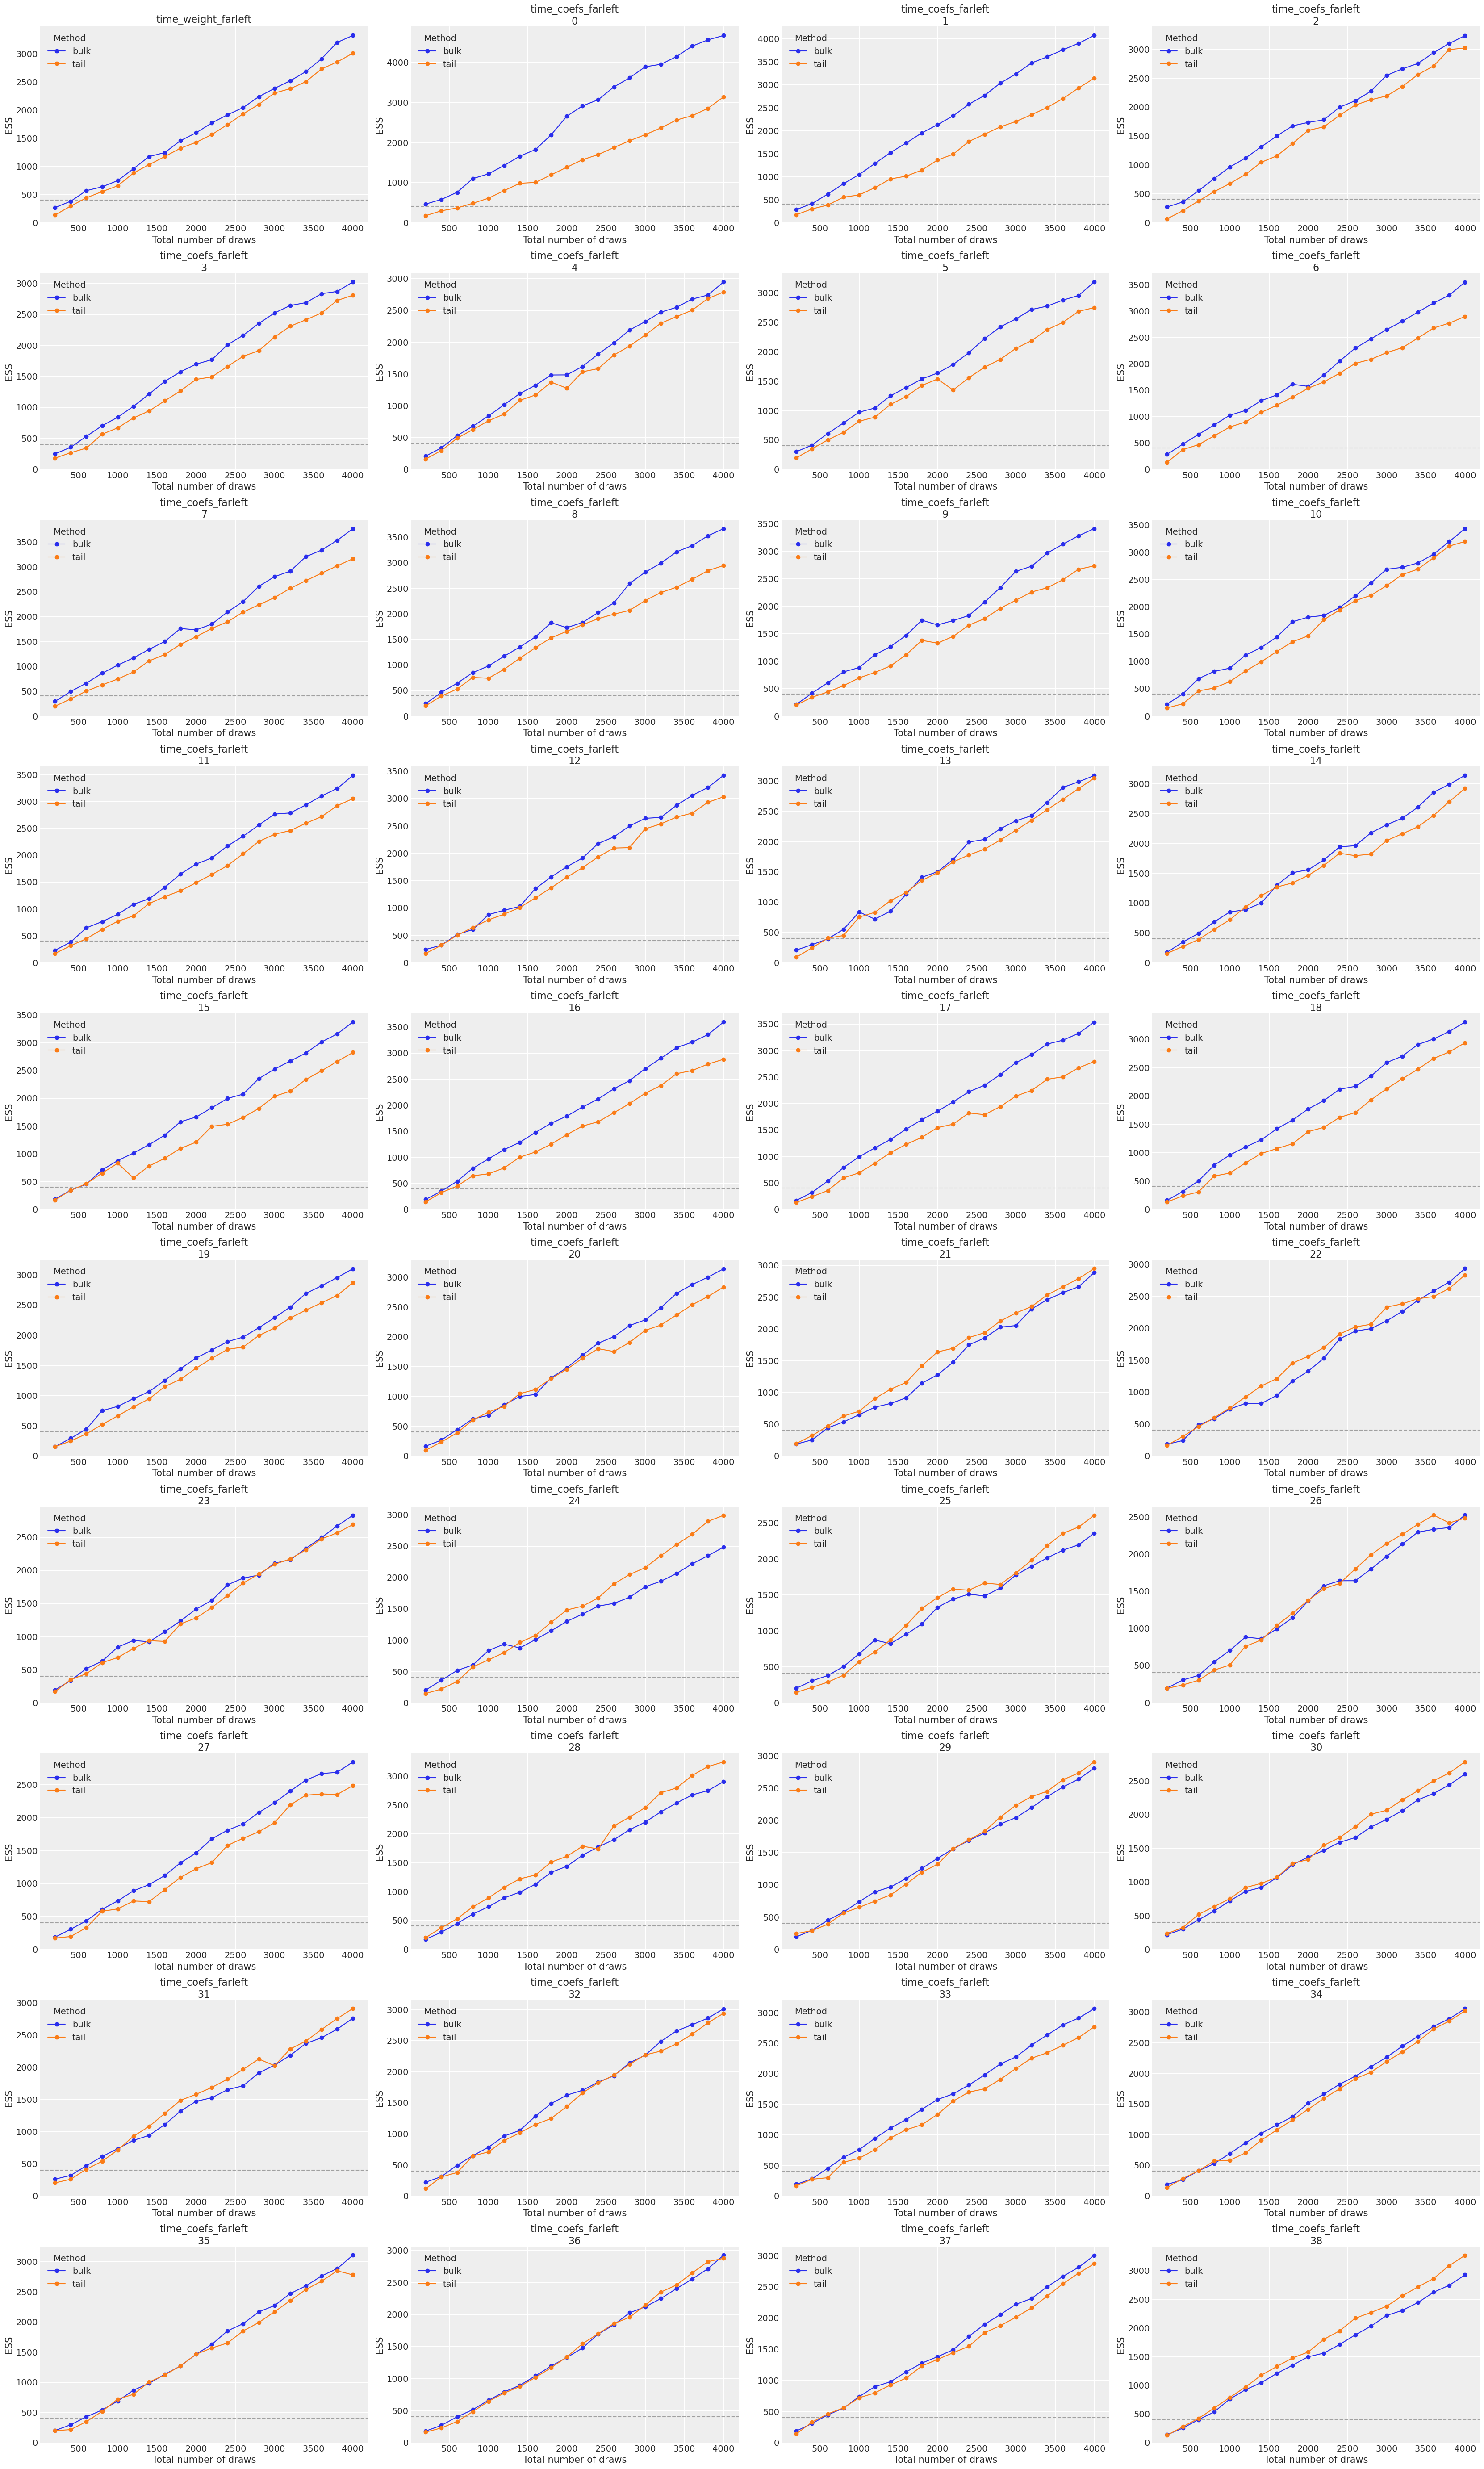

In [25]:
arviz.plot_ess(trace_simple, kind="evolution", var_names=["time_weight", "time_coefs"], filter_vars="regex");

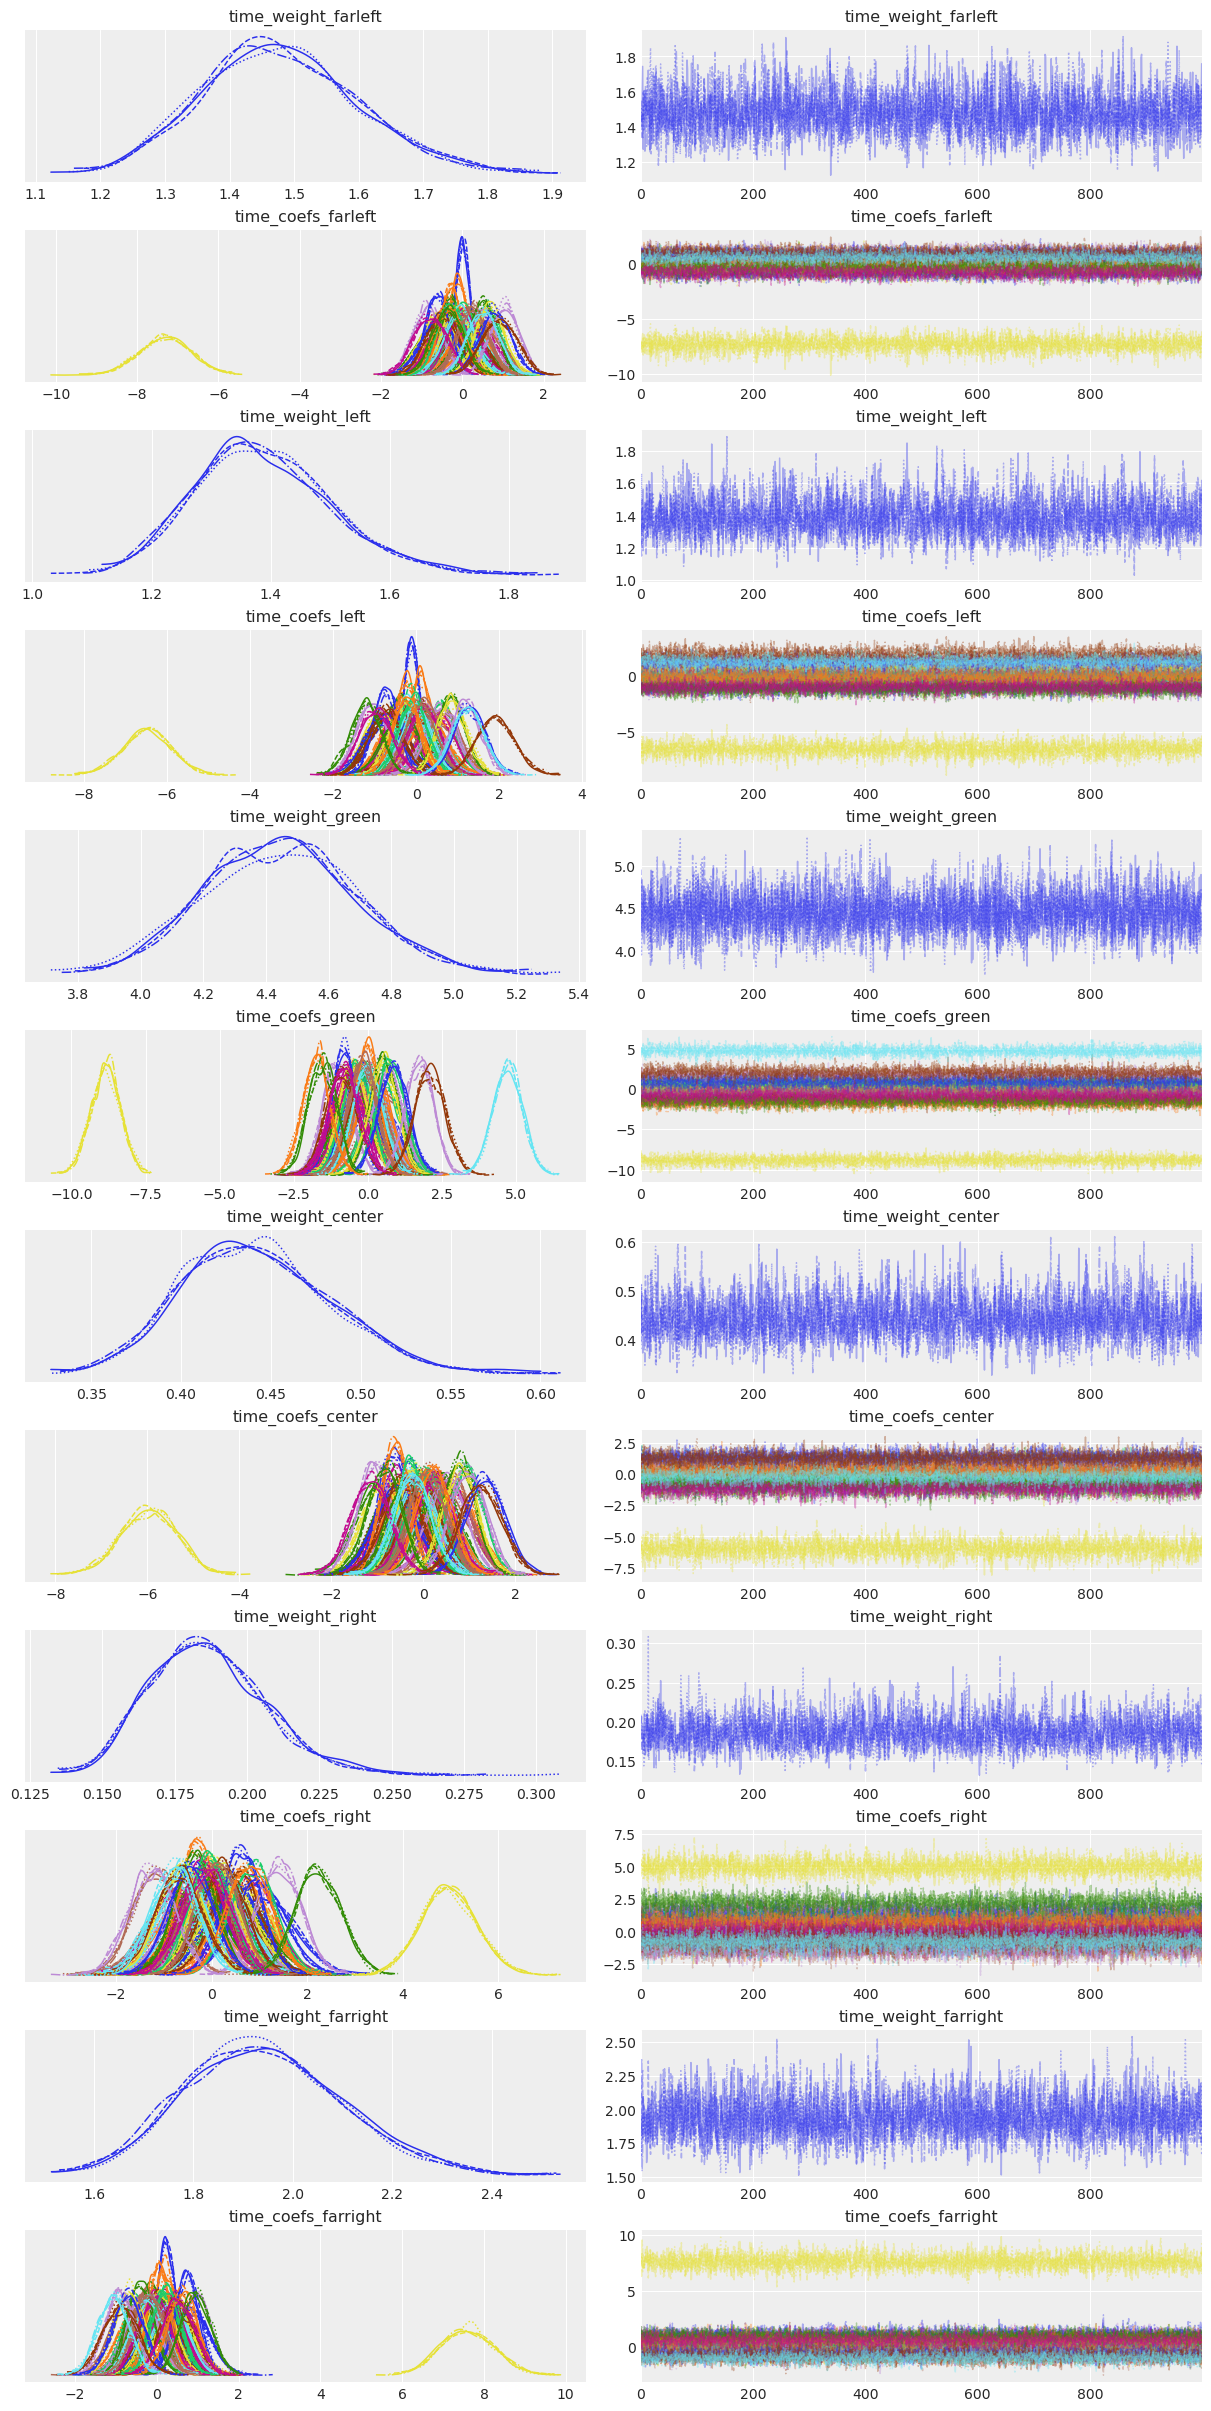

In [26]:
arviz.plot_trace(trace_simple, var_names=["~cutpoints", "~time_effect", "~results_probs"], filter_vars="regex");

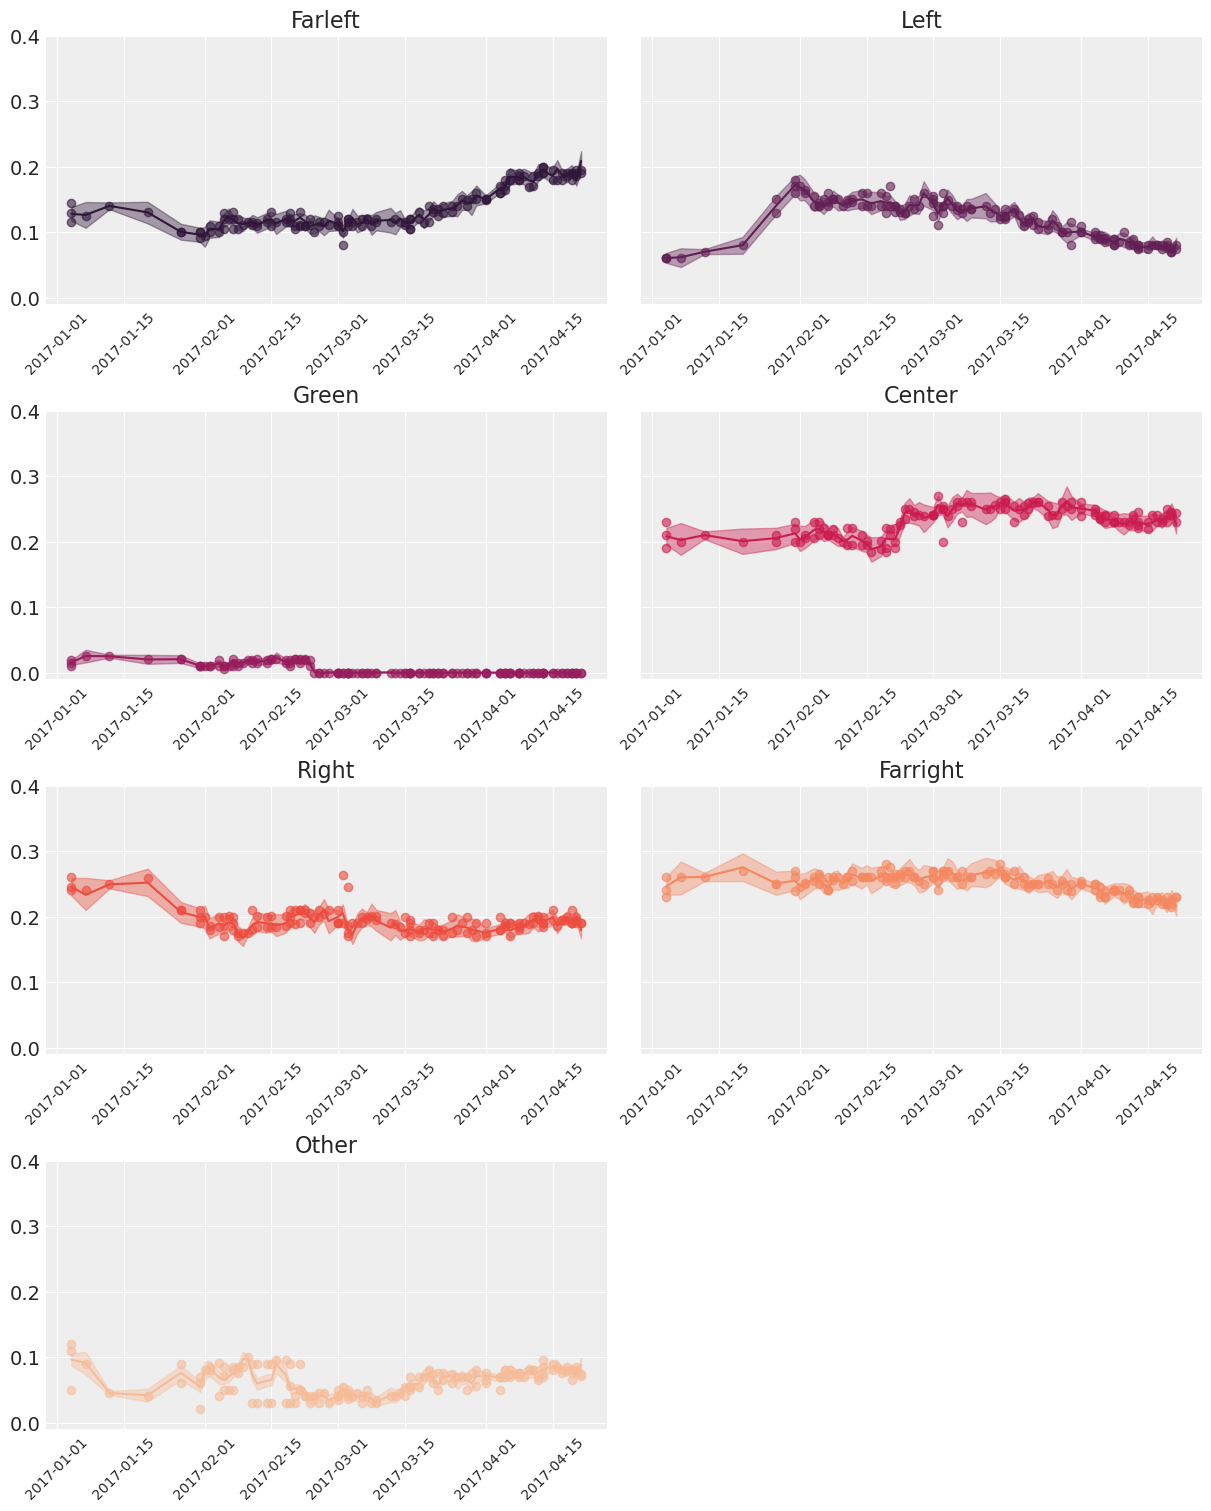

In [28]:
fig, axes = plt.subplots(4, 2, figsize=(12, 15), sharey=True)
axes = axes.ravel()
axes[-1].remove()
colors = sns.color_palette("rocket", n_colors=7, as_cmap=False)

post_means = trace_simple.posterior["results_probs"].mean(("chain", "draw"))
hdi = arviz.hdi(trace_simple.posterior)

for i, p in enumerate(COORDS["parties_complete"]):
    axes[i].plot(
        polls["date"], polls[p] / polls["samplesize"], "o", color=colors[i], alpha=0.6
    )
    axes[i].fill_between(
        polls["date"],
        hdi.sel(parties_complete=p, hdi="lower")["results_probs"],
        hdi.sel(parties_complete=p, hdi="higher")["results_probs"],
        color=colors[i],
        alpha=0.4
    )
    axes[i].plot(polls["date"], post_means.sel(parties_complete=p), color=colors[i])
    axes[i].tick_params(axis="x", labelrotation=45, labelsize=10)
    axes[i].set(title=p.title(), ylim=(-0.01, 0.4))

# out-of-sample prediction
# GP reverting to fundamentals prior

## Unpooled fundamentals model

In [8]:
region_idx, COORDS["regions"] = pd.factorize(
    subset.index.get_level_values("region"), sort=True
)

In [80]:
with pm.Model(coords=COORDS) as m_unpooled:

    initval = np.tile(
        np.arange(len(COORDS["parties"])) - 2.5, reps=(len(COORDS["regions"]), 1)
    )
    cutpoints = pm.Normal(
        "cutpoints",
        mu=initval,
        sigma=3.0,
        initval=initval,
        transform=pm.distributions.transforms.ordered,
        dims=("regions", "parties"),
    )

    pm.OrderedMultinomial(
        "results",
        eta=0,
        cutpoints=cutpoints[region_idx],
        n=subset[COORDS["parties_complete"]].sum(1).values,
        observed=subset[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace_unpooled = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["observations", "parties_complete"]},
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[18  6]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


0, dim: observations, 140 =? 140


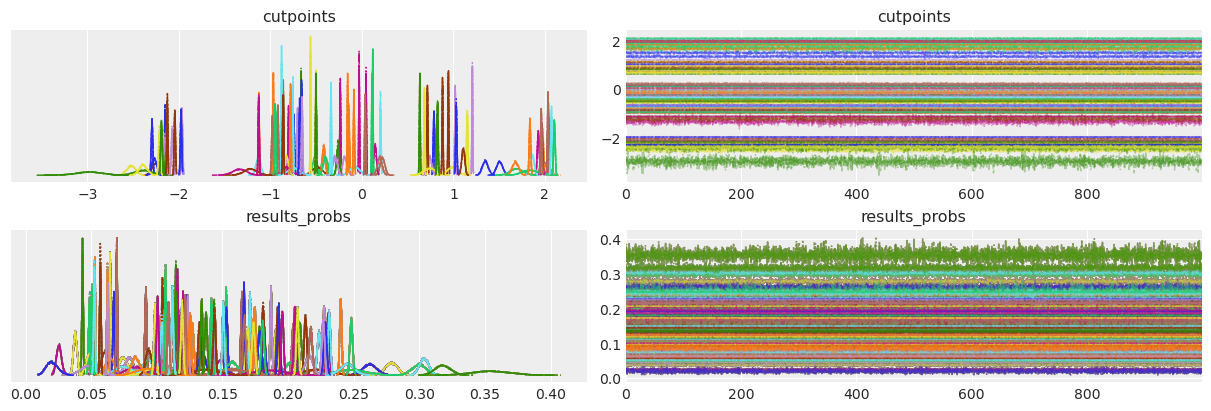

In [82]:
arviz.plot_trace(trace_unpooled);

## Hierarchical fundamentals model

In [10]:
with pm.Model(coords=COORDS) as m_hierarchical:

    init_mean = np.arange(len(COORDS["parties"])) - 2.5
    mean = pm.Normal(
        "cutpoint_mean",
        mu=init_mean,
        sigma=3.0,
        initval=init_mean,
        transform=pm.distributions.transforms.ordered,
        dims="parties",
    )
    sd = pm.HalfNormal("cutpoint_sd")

    init_cut = np.tile(
        np.arange(len(COORDS["parties"])) - 2.5, reps=(len(COORDS["regions"]), 1)
    )
    cutpoints = pm.Normal(
        "cutpoints",
        mu=mean,
        sigma=sd,
        initval=init_cut,
        transform=pm.distributions.transforms.ordered,
        dims=("regions", "parties"),
    )

    pm.OrderedMultinomial(
        "results",
        eta=0,
        cutpoints=cutpoints[region_idx],
        n=subset[COORDS["parties_complete"]].sum(1).values,
        observed=subset[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace_hierarchical = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["observations", "parties_complete"]},
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoint_mean, cutpoint_sd, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


0, dim: observations, 51 =? 51


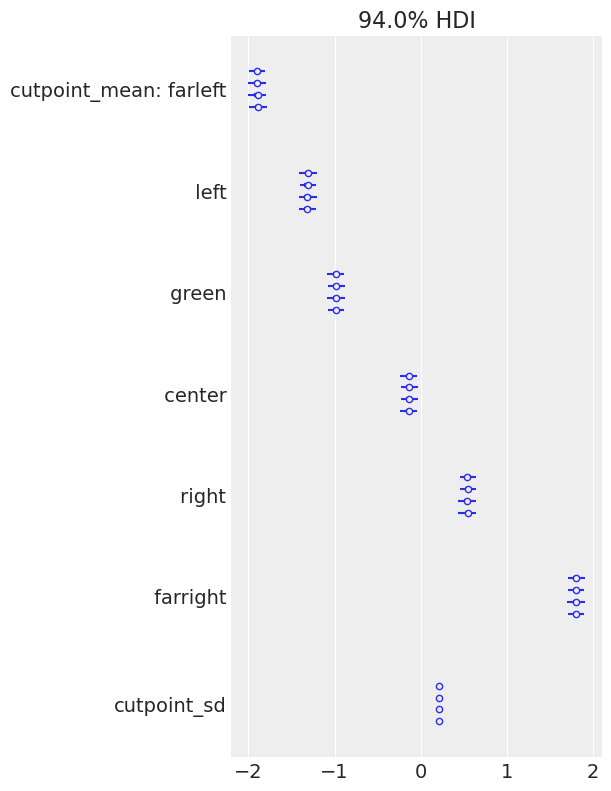

In [11]:
arviz.plot_forest(trace_hierarchical, var_names="cutpoint_", filter_vars="like");

In [15]:
def compute_p_from_cutpoints(posterior):
    # need to include eta in computation
    #   pa = sigmoid(cutpoints - at.shape_padright(eta))

    p_cum = logistic(posterior.cutpoints)

    zeros = xarray.zeros_like(p_cum.sel(parties="farleft"))
    zeros.coords["parties"] = "dummy"

    ones = xarray.ones_like(p_cum.sel(parties="farleft"))
    ones.coords["parties"] = "other"

    return xarray.concat([zeros, p_cum, ones], dim="parties").diff(dim="parties")

In [12]:
p_cum = compute_p_from_cutpoints(trace_hierarchical.posterior)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

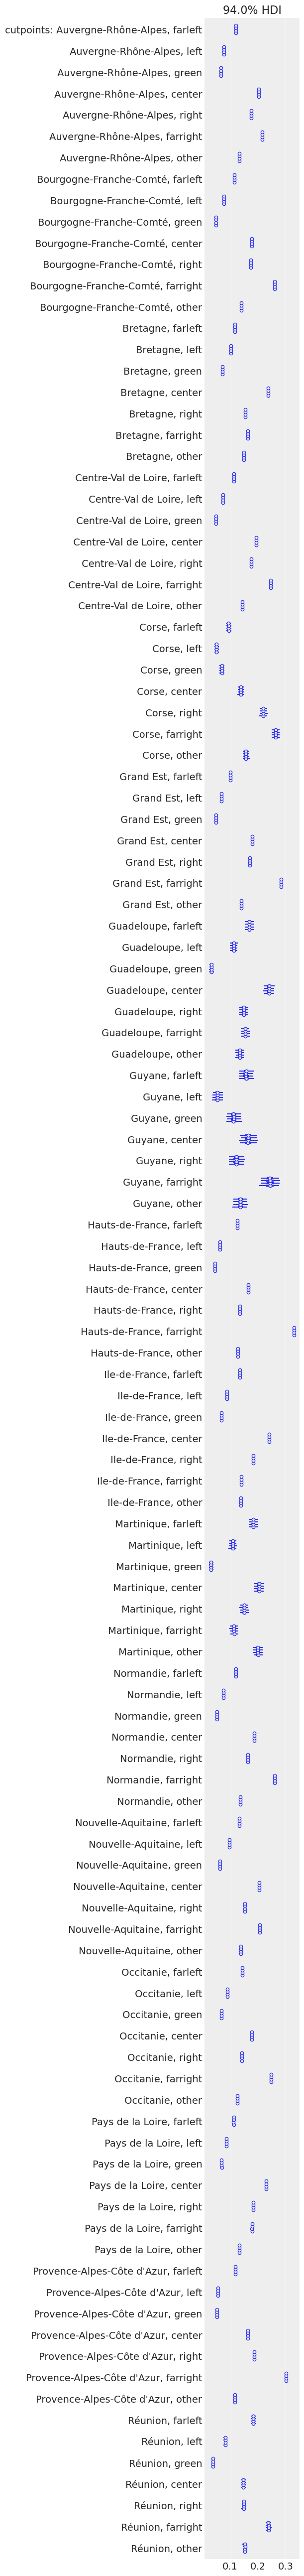

In [14]:
arviz.plot_forest(p_cum);

## Hierarchical fundamentals model with one predictor

In [9]:
unemp = pd.read_excel(
    "../../data/predictors/chomage_reg_depart_trim.xls",
    sheet_name="Région",
    header=3,
    nrows=19,
).iloc[2:]

# remove accents and special characters, then remove hyphens
unemp["normalized_region"] = unemp["Libellé"].str.lower().str.replace("-", " ").values

unemp = unemp.drop(["Code", "Libellé"], axis=1).set_index("normalized_region")

In [10]:
# as timestamps variables:
unemp.columns = pd.period_range(
    start=unemp.columns[0].split("_")[1], periods=unemp.shape[1], freq="Q"
)
unemp.columns.name = "quarter"
unemp = pd.DataFrame(unemp.stack().swaplevel(), columns=["unemployment"]).sort_index()

In [11]:
# normalize regions of data before joining
subset["normalized_region"] = (
    subset.reset_index()
    .region.str.lower()
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
    .str.replace("-", " ")
    .values
)

subset = subset.reset_index()

# add quarters to results dataframe:
subset["quarter"] = pd.DatetimeIndex(subset["election_day"].values).to_period("Q")
subset = subset.set_index(["quarter", "normalized_region"]).sort_index()

In [12]:
subset = (
    subset.merge(unemp, left_index=True, right_index=True)
    .reset_index(drop=True)
    .set_index(["election_day", "region"])
)

In [101]:
with pm.Model(coords=COORDS) as m_fundamentals:

    # hierarchical layer cutpoints
    init_mean = np.arange(len(COORDS["parties"])) - 2.5
    mean = pm.Normal(
        "cutpoint_mean",
        mu=init_mean,
        sigma=3.0,
        initval=init_mean,
        transform=pm.distributions.transforms.ordered,
        dims="parties",
    )
    sd = pm.HalfNormal("cutpoint_sd")

    # cutpoints
    init_cut = np.tile(
        np.arange(len(COORDS["parties"])) - 2.5, reps=(len(COORDS["regions"]), 1)
    )
    cutpoints = pm.Normal(
        "cutpoints",
        mu=mean,
        sigma=sd,
        initval=init_cut,
        transform=pm.distributions.transforms.ordered,
        dims=("regions", "parties"),
    )

    # regression
    regression_mean = pm.Normal("regression_mean")
    shrinkage = pm.HalfNormal("regression_shrinkage")
    bU = pm.Normal("unemp_effect", regression_mean, shrinkage, dims="regions")
    U = pm.Data("unemp_data", subset.unemployment.values)  # dims="observations"
    reg_idx = pm.Data("region_idx", region_idx)  # dims="observations"
    eta = pm.Deterministic("eta", bU[reg_idx] * U, dims="observations")

    pm.OrderedMultinomial(
        "results",
        eta=eta,
        cutpoints=cutpoints[reg_idx],
        n=subset[COORDS["parties_complete"]].sum(1).values,
        observed=subset[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace_fundamentals = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["observations", "parties_complete"]},
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoint_mean, cutpoint_sd, cutpoints, regression_mean, regression_shrinkage, unemp_effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.


0, dim: observations, 51 =? 51


In [17]:
arviz.plot_trace(
    trace_fundamentals,
    var_names=["cutpoint_", "regression_", "unemp_effect"],
    filter_vars="like",
);

In [18]:
arviz.plot_forest(trace_fundamentals, var_names=["cutpoint_"], filter_vars="like");

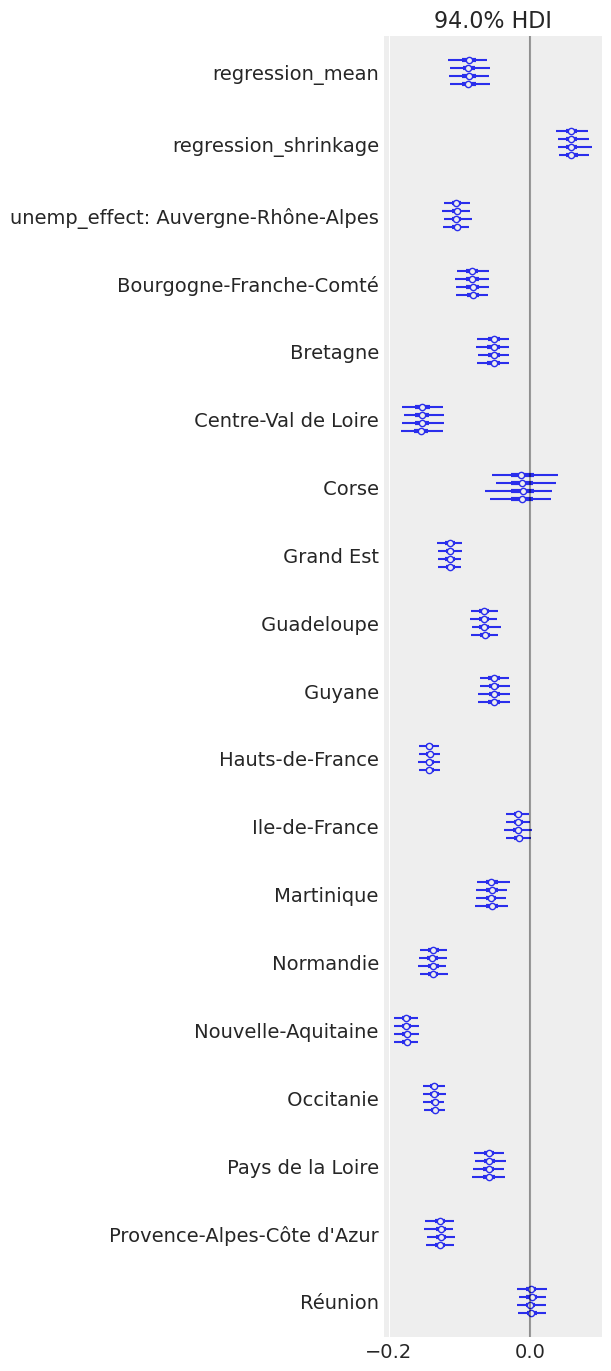

In [19]:
ax = arviz.plot_forest(
    trace_fundamentals, var_names=["regression_", "unemp_effect"], filter_vars="like"
)
ax[0].axvline(c="k", alpha=0.4);

In [20]:
ref_vals = subset[COORDS["parties_complete"]].div(
    subset[COORDS["parties_complete"]].sum(1).values, axis="rows"
)

In [21]:
ref_vals.loc[(slice(None), "Auvergne-Rhône-Alpes"), :]

farleft      left     green    center  \
election_day region                                                         
2014-05-25   Auvergne-Rhône-Alpes  0.061463  0.136584  0.101036  0.099272   
2017-04-23   Auvergne-Rhône-Alpes  0.192363  0.061255  0.000000  0.244973   
2019-05-26   Auvergne-Rhône-Alpes  0.057686  0.059939  0.149698  0.226537   

                                      right  farright     other  
election_day region                                              
2014-05-25   Auvergne-Rhône-Alpes  0.217855  0.238162  0.145629  
2017-04-23   Auvergne-Rhône-Alpes  0.202011  0.207169  0.092229  
2019-05-26   Auvergne-Rhône-Alpes  0.103804  0.209937  0.192399

In [22]:
trace_fundamentals.posterior["results_probs"].sel(
    observations=[
        ("2014-05-25", "Auvergne-Rhône-Alpes"),
        ("2017-04-23", "Auvergne-Rhône-Alpes"),
        ("2019-05-26", "Auvergne-Rhône-Alpes"),
    ]
).mean(("chain", "draw")).to_dataframe().unstack()

results_probs                                \
parties_complete                        farleft      left     green    center   
election_day region                                                             
2014-05-25   Auvergne-Rhône-Alpes      0.128062  0.083051  0.071192  0.206936   
2017-04-23   Auvergne-Rhône-Alpes      0.122358  0.080212  0.069305  0.204366   
2019-05-26   Auvergne-Rhône-Alpes      0.112648  0.075208  0.065872  0.199208   

                                                                 
parties_complete                      right  farright     other  
election_day region                                              
2014-05-25   Auvergne-Rhône-Alpes  0.175208  0.208430  0.127121  
2017-04-23   Auvergne-Rhône-Alpes  0.176504  0.214246  0.133009  
2019-05-26   Auvergne-Rhône-Alpes  0.178273  0.224596  0.144195

In [23]:
arviz.plot_posterior(
    trace_fundamentals,
    var_names="results_probs",
    coords={
        "observations": [
            ("2014-05-25", "Auvergne-Rhône-Alpes"),
            ("2017-04-23", "Auvergne-Rhône-Alpes"),
            ("2019-05-26", "Auvergne-Rhône-Alpes"),
        ]
    },
    ref_val=ref_vals.loc[(slice(None), "Auvergne-Rhône-Alpes"), :].stack().tolist(),
);

## Out-of-sample prediction

To be used as priors for each region and party in the dynamic model.

In [118]:
latest_update = unemp.sort_index().index.get_level_values(0)[-1]
latest_U = unemp.sort_index().loc[latest_update, :].values.squeeze()

In [103]:
with m_fundamentals:
    pm.set_data(
        {"unemp_data": latest_U, "region_idx": np.arange(len(COORDS["regions"]))}
    )
    post_pred = pm.sample_posterior_predictive(
        trace_fundamentals, var_names=["eta", "cutpoints"]
    )

In [174]:
p_cum = logistic(post_pred["cutpoints"] - post_pred["eta"][..., None])
p_cum = np.c_[
    np.zeros_like(p_cum[..., 0][..., None]),
    p_cum,
    np.ones_like(p_cum[..., 0][..., None]),
]
post_probs = xarray.DataArray(
    p_cum[..., 1:] - p_cum[..., :-1],
    dims=["samples", "regions", "parties_complete"],
    coords={
        "samples": np.arange(p_cum.shape[0]),
        "regions": COORDS["regions"],
        "parties_complete": COORDS["parties_complete"],
    },
)

In [178]:
post_probs.mean("samples")

<xarray.DataArray (regions: 17, parties_complete: 7)>
array([[0.12656514, 0.07028519, 0.05937612, 0.17289791, 0.15160049,
        0.23631317, 0.18296198],
       [0.10708404, 0.06197504, 0.05382133, 0.16265403, 0.15108637,
        0.25093529, 0.2124439 ],
       [0.09006373, 0.05430731, 0.04819008, 0.15060826, 0.14779985,
        0.26432284, 0.24470793],
       [0.1689877 , 0.08613644, 0.0690912 , 0.18627161, 0.14780152,
        0.20407813, 0.13763339],
       [0.07203319, 0.04551822, 0.04061623, 0.13447501, 0.14109736,
        0.27518536, 0.29107461],
       [0.14265887, 0.07665991, 0.06374865, 0.17936238, 0.15091871,
        0.22373037, 0.1629211 ],
       [0.19491154, 0.09372572, 0.07301199, 0.18929838, 0.14202986,
        0.18756137, 0.11946113],
       [0.16449776, 0.08479089, 0.0678306 , 0.18380343, 0.14641572,
        0.20852223, 0.14413936],
       [0.20313876, 0.0958272 , 0.07477895, 0.19135601, 0.14071285,
        0.18131786, 0.11286837],
       [0.07508181, 0.04672122, 0.04225785, 0.13799079, 0.1418778 ,
        0.27508772, 0.28098282],
       [0.13009923, 0.07157834, 0.06005343, 0.17387889, 0.15086274,
        0.23387603, 0.17965132],
       [0.16606681, 0.08445317, 0.06898102, 0.18508316, 0.14780436,
        0.20720442, 0.14040707],
       [0.19318222, 0.09389688, 0.07354798, 0.19017199, 0.14270681,
        0.18756979, 0.11892432],
       [0.19376518, 0.09356868, 0.07392931, 0.18944903, 0.14326848,
        0.18741767, 0.11860165],
       [0.0946003 , 0.0563763 , 0.04960706, 0.15417897, 0.14840697,
        0.26125944, 0.23557096],
       [0.17446625, 0.08767309, 0.07031546, 0.18759329, 0.14598792,
        0.20061569, 0.1333483 ],
       [0.0654172 , 0.04125295, 0.03809779, 0.12774045, 0.13653596,
        0.27815973, 0.31279592]])
Coordinates:
  * regions           (regions) object 'Auvergne-Rhône-Alpes' ... 'Réunion'
  * parties_complete  (parties_complete) <U8 'farleft' 'left' ... 'other'

In [180]:
arviz.to_netcdf(post_probs, "fundamentals_preds.nc")

'fundamentals_preds.nc'

In [181]:
%load_ext watermark
%watermark -a AlexAndorra -n -u -v -iv

Author: AlexAndorra

Last updated: Fri Jul 09 2021

Python implementation: CPython
Python version       : 3.9.4
IPython version      : 7.24.1

pymc3     : 4.0
matplotlib: 3.4.2
numpy     : 1.20.3
scipy     : 1.6.3
aesara    : 2.0.10
arviz     : 0.11.2
xarray    : 0.18.2
pandas    : 1.2.4
seaborn   : 0.11.1

